In [3]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, build_wandb_run
from FashionDataset import BottomCenterCrop
from constants import TRAIN_PATH

In [4]:
import torch
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)
dtype = torch.float32

In [5]:
def _get_prompt_embeddings():
    """ get inital prompt embeddings to help model """
    # text encoder components
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)#.to(device)

    prompt = "Ramadan Vibes, moon behind, holdening latent, ramdan atmosphere, ramadan cannon, quran, An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality, full cloth"
    negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
        
    # Tokenize positive and negative prompts
    positive_token_ids = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)
    negative_token_ids = tokenizer(negative_prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)

    # Generate embeddings
    with torch.no_grad():
        positive_embeddings = text_encoder(positive_token_ids).last_hidden_state.type(dtype).to(device)
        negative_embeddings = text_encoder(negative_token_ids).last_hidden_state.type(dtype).to(device)

        combined_embeddings = torch.cat([negative_embeddings, positive_embeddings], dim=0)#.type(dtype)
    
    return positive_embeddings, negative_embeddings, combined_embeddings

positive_embeddings, negative_embeddings, combined_embeddings =  _get_prompt_embeddings()


KeyboardInterrupt: 

In [ ]:
def encode_vae(img_clean, vae):
    if img_clean.ndim == 3:
        img_clean = img_clean.unsqueeze(0) # VAE excpect (B, C, H, W)
    img_clean = img_clean.type(vae.dtype).to(vae.device)
    
    with torch.no_grad():
        img_latents = vae.encode(img_clean).latent_dist.sample() * vae.config.scaling_factor
    return img_latents

def decode_vae(img_latents, vae):
    outputs = img_latents / vae.config.scaling_factor
    with torch.no_grad():
        outputs  = vae.decode(outputs).sample
    return outputs

# Load HQ Image

In [ ]:
img_path = TRAIN_PATH / "MEN_Jackets_Vests_id_00004882_02_1_front.png"
img = Image.open(img_path)
img.size

(750, 1101)

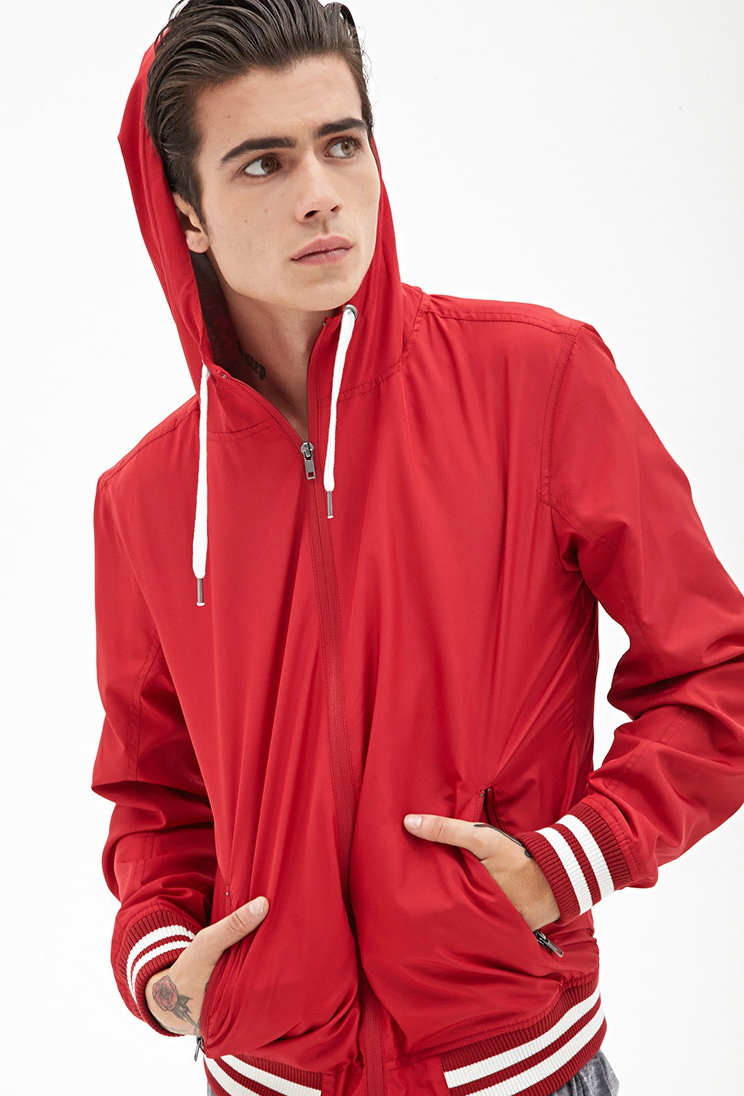

In [ ]:
original_image = (1101, 750)


image_resize = (1101, 750) # divided by 3 (H, W)
image_crop = (1096, 744) # H, W

transform = transforms.Compose([
    transforms.Resize(image_resize),
    BottomCenterCrop(image_crop),  # Custom bottom-center crop
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


img_clean = transform(img)
show_images(img_clean)

# Load Models

In [ ]:
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"    
vae_link = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/vae-ft-mse-840000-ema-pruned.ckpt"
inpainting_link = "https://huggingface.co/SG161222/Realistic_Vision_V6.0_B1_noVAE/blob/main/Realistic_Vision_V6.0_NV_B1_inpainting_fp16.safetensors"


scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae = AutoencoderKL.from_single_file(vae_link, torch_dtype=dtype).to(device)

unet = UNet2DConditionModel.from_pretrained(model_id, 
                                            subfolder="unet",
                                            torch_dtype=dtype
                                        ).to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# Inference Loop

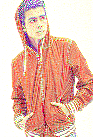

In [ ]:
# 1. generate latents
latents = encode_vae(img_clean, vae)
show_images(latents.type(torch.float32))


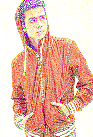

In [ ]:
# 2. add noise to latents
noise = torch.randn_like(latents, device=device, dtype=dtype)

init_timestep = 25
scheduler.set_timesteps(init_timestep)
noisy_latents = scheduler.add_noise(latents, noise, torch.tensor([init_timestep]))

show_images(noisy_latents.type(torch.float32))

  0%|          | 0/51 [00:00<?, ?it/s]

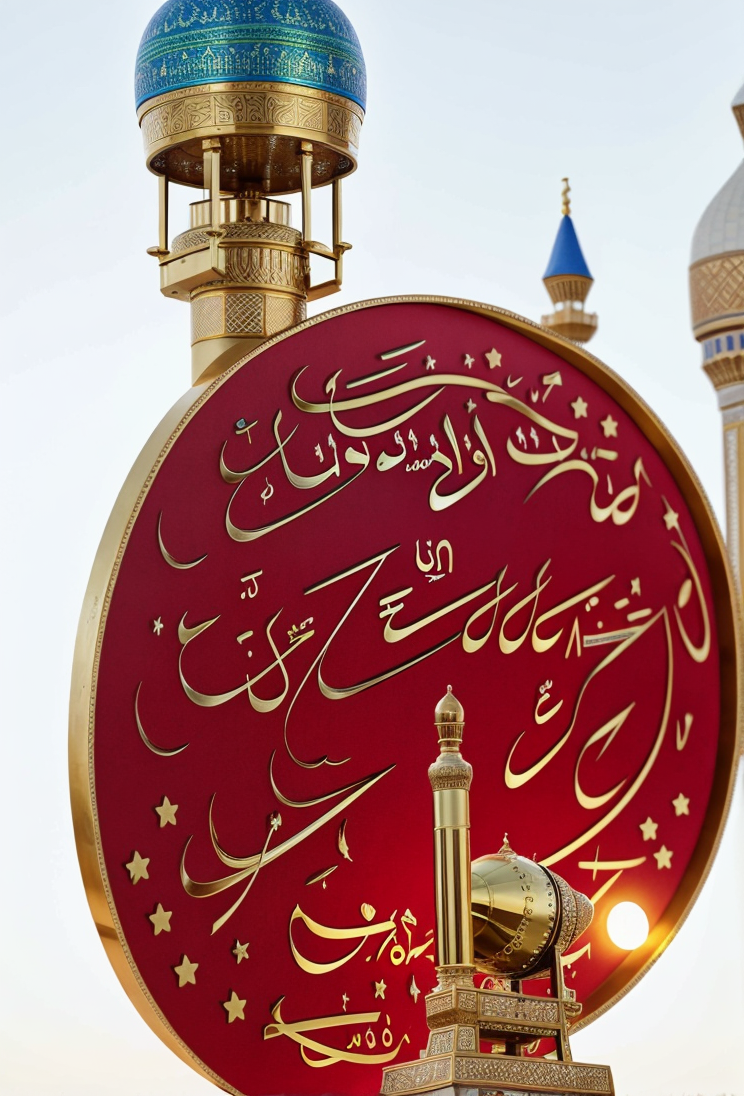

In [ ]:
# 1. generate latents
latents = encode_vae(img_clean, vae)
# 2. add noise to latents
noise = torch.randn_like(latents, device=device, dtype=dtype)

start_step = 10
scheduler.set_timesteps(50)
noisy_latents = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))

#3. denoising loop
bs = noisy_latents.shape[0] # batch size
guidance_scale = 2.0

embeddings = torch.cat([
                        positive_embeddings.repeat(bs, 1, 1), 
                        negative_embeddings.repeat(bs, 1, 1)
])

latents_ = noisy_latents.clone()
for i, t in enumerate(tqdm(scheduler.timesteps)):
    if i >= start_step: ######
        latents_in = torch.cat([latents_] * 2)
        latents_in = scheduler.scale_model_input(latents_in, t)
        with torch.no_grad():
            noise_pred = unet(latents_in, t, encoder_hidden_states=embeddings).sample
            
        noise_pos, noise_neg = noise_pred.chunk(2)
        noise_pred = noise_neg + guidance_scale * (noise_pos - noise_neg)
        latents_ = scheduler.step(noise_pred, t, latents_).prev_sample
        
    
pred = decode_vae(latents_, vae)
show_images(pred.type(torch.float32))